In [ ]:
<img align="right" src="/additional_data/banner.png" style="width:1100px;">

# Classification of satellite data with random forest and k-means algorithms

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Products used:** 
[s2a_l2a](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm)

* **Special requirements:** None
* **Prerequisites:** Basic knowledge of loading data and the xarray data structure is helpful.

## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by eo2cube, subnational data cubes or earth oservation data cubes in general. This may include information about why the particular technique or approach is useful or required.
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Holzwarth et al. 2020](https://www.mdpi.com/2072-4292/12/21/3570/htm)).

## Description
This notebook will use unsupervised and supervised methods to gain additional information from satellite data which are available in the data cube.

1. How to use the k-means algorithm to group your data pixels into spectrally similar clusters
2. How to apply the random forest algorithm to train a classifier on training data and classify an image with it.
3. Some tweaking options
4. (maybe) more approaches

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

In [5]:
%matplotlib inline
# basic imports
import sys
import datacube

import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from odc.ui import with_ui_cbk # progress bar
from rasterio import features

# datacube scripts
sys.path.append('../../eo2cube-tools/eo2cube_tools')
import unpacks2scl
sys.path.append('/datacube/data_cube_notebooks/datacube/Scripts')
from ClassificationToolsImproved import randomforest_train, randomforest_classify
from SpatialTools import array_to_geotiff

ModuleNotFoundError: No module named 'utils.data_cube_utilities'; 'utils' is not a package

### Connect to the datacube

Connect to the datacube so we can access eo2cube data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='classifications',
                       config='/home/datacube/.datacube.conf')

### Analysis parameters

These parameters are used for the following analysis. 
* `latitude_extents`, `longitude_extents`: define the extent of your area of interest in degrees (must be in Burkina Faso).
* `time`: load data within this time frame for your analysis. In this area, your result is influenced by the rainy/ dry season differences.
* `nodataval`: define this value as the no data value for any tif file you want to save your results in.

In [3]:
latitude_extents, longitude_extents = (11.5, 11.7), (-0.9,-0.7)
time = ('2019-10-01', '2019-11-30')
nodataval = -9999

## Define functions for:
1. calculating indices
2. finding useable timesteps in given timespan
3. cloud masking with scl
4. making median composite for one time frame
--> easier to use and does garbage collection

concerning indices: https://medium.com/regen-network/remote-sensing-indices-389153e3d947 \
https://www.indexdatabase.de/search/?s=EVI

In [3]:
def calc_ndvi(nir, red):
    ndvi = (nir-red)/(nir+red)
    return ndvi

def calc_mndwi(green, swir):
    mndwi = (green-swir)/(green+swir)
    return mndwi

def calc_ndbi(swir,nir):
    ndbi = (swir-nir)/(swir+nir)
    return ndbi

In [3]:
def tasseled_cap(sensor_data, tc_bands=['greenness', 'brightness', 'wetness'],
                 drop=True):
    """
    MODIFIED FOR SENTINEL DATA - coefficients from SHI & XU 2019 (6-band option) 
    https://doi.org/10.1109/JSTARS.2019.2938388
    copied from scripts/BandIndices.py
    
    Computes tasseled cap wetness, greenness and brightness bands from a six
    band xarray dataset, and returns a new xarray dataset with old bands
    optionally dropped.
    
    Last modified: June 2018
    Authors: Robbi Bishop-Taylor, Bex Dunn
    
    :attr sensor_data: input xarray dataset with six Landsat bands
    :attr tc_bands: list of tasseled cap bands to compute
    (valid options: 'wetness', 'greenness','brightness')
    :attr drop: if 'drop = False', return all original bands
    :returns: xarray dataset with newly computed tasseled cap bands
    """

    # Copy input dataset
    output_array = sensor_data.copy(deep=True)

    # Coefficients for each tasseled cap band
    wetness_coeff = {'blue': 0.2578, 'green': 0.2305, 'red': 0.0883,
                     'nir': 0.1071, 'swir1': -0.7611, 'swir2': -0.5308}
    
    greenness_coeff = {'blue': -0.3599, 'green': -0.3533, 'red': -0.4734,
                       'nir': 0.6633, 'swir1': 0.0087, 'swir2': -0.2856}
    
    brightness_coeff = {'blue': 0.3510, 'green': 0.3813, 'red': 0.3437,
                        'nir': 0.7196, 'swir1': 0.2396, 'swir2': 0.1949}
    
    # Dict to use correct coefficients for each tasseled cap band
    analysis_coefficient = {'wetness': wetness_coeff,
                            'greenness': greenness_coeff,
                            'brightness': brightness_coeff}

    # For each band, compute tasseled cap band and add to output dataset
    for tc_band in tc_bands:
        # Create xarray of coefficient values used to multiply each band of input
        coeff = xr.Dataset(analysis_coefficient[tc_band])
        sensor_coeff = sensor_data * coeff

        # Sum all bands
        output_array[tc_band] = sensor_coeff.blue + sensor_coeff.green + \
                                sensor_coeff.red + sensor_coeff.nir + \
                                sensor_coeff.swir1 + sensor_coeff.swir2

    # If drop = True, remove original bands
    if drop:
        bands_to_drop = list(sensor_data.data_vars)
        output_array = output_array.drop(bands_to_drop)

    return output_array

In [4]:
def find_usable_timesteps(time, platf, product, lat, lon):
    '''
    takes a time frame (and other necessary load info) to find all non-empty datasets using the scl layer
    and returns a list of their time stamps 
    '''
    scl = dc.load(latitude =  lat,
                  longitude = lon,
                  platform = platf,
                  time = time,
                  skip_broken_datasets=True,
                  product = product,
                  measurements = ['scl'])
    sclmean = scl.mean(dim = ('latitude', 'longitude'))
    usable = sclmean.time.where(sclmean.scl != 0, drop=True)
    print(len(usable.time), "out of", len(sclmean.time), "entries were usable")
    
    return usable.time.values

In [5]:
def unpack_bits(land_cover_endcoding, data_array, cover_type):
    """
    Description:
    adaptation of unpack_bits for sentinel
    Unpack bits for end of ls7 and ls8 functions 
    -----
    Input:
        land_cover_encoding(dict hash table) land cover endcoding provided by scl 
        data_array(xarray DataArray)
        cover_type(String) type of cover
    Output:
        unpacked DataArray
    """
    boolean_mask = np.isin(data_array.values, land_cover_endcoding[cover_type]) 
    return xr.DataArray(boolean_mask.astype(bool),
                        coords = data_array.coords,
                        dims = data_array.dims,
                        name = cover_type + "_mask",
                        attrs = data_array.attrs)


def s2_unpack_qa(data_array , cover_type):
    '''
    adaptation of ls_unpack_qa for sentinel 2 data
    uses unpack_bits.
    ---
    cover_type: type to be kept
    data_array: data to be masked
    '''

    land_cover_endcoding = dict( no_class     =[0,1,7],
                                 no_data      =[0],
                                 dark         =[2],
                                 shadow       =[3],
                                 snow         =[11],
                                 cloud        =[8,9,10],
                                 med_conf_cl  =[8],
                                 high_conf_cl =[9],
                                 cirrus       =[10],
                                 clear        =[4,5,6,11],
                                 clear_no_water = [4,5,11]
                               )
    return unpack_bits(land_cover_endcoding, data_array, cover_type)

In [6]:
def prepare_one_timestep(time, lat, lon, platf = 'SENTINEL_2', product ='s2_l2a_burkinafaso', measurements = ['red','green','blue','nir','swir1','scl'], keep_water=True):
    '''
    load data for the specified timespan from sentinel 2 dataset (default). 
    drop empty datasets, mask clouds with scl, add ndvi+ndbi+mndwi and create a median composite of all remaining data.
    '''
    usable = find_usable_timesteps(time, platf, product, lat, lon)
    
    dataset = dc.load(latitude =  lat,
                      longitude = lon,
                      platform = platf,
                      time = time,
                      skip_broken_datasets=True,
                      product = product,
                      measurements = measurements,
                      progress_cbk=with_ui_cbk())
    # improve dataset
    print('cleaning dataset and adding indices')
    dataset = dataset.sel(time=usable, drop=True) #.time.values
    if keep_water:
        mask = s2_unpack_qa(dataset.scl, 'clear') # seems to remove important parts as well?
    else:
        mask = s2_unpack_qa(dataset.scl, 'clear_no_water')
        print('cloud and water masked')
    # TODO re-convert to int datatype here (not necessary, scaling turns it into float anyways)
    dataset = dataset.where(mask)
    
    dataset = dataset.drop_vars('scl')
    dataset['ndvi'] = calc_ndvi(dataset.nir, dataset.red)
    dataset['ndbi'] = calc_ndbi(dataset.swir1, dataset.nir)
    dataset['mndwi'] = calc_mndwi(dataset.green, dataset.swir1)
    
    print('making composite')
    composite = dataset.median(dim='time', skipna = True, keep_attrs = True)
    
    return composite

In [6]:
def prepare_timestep_for_tc(time, lat, lon, platf = 'SENTINEL_2', product ='s2_l2a_burkinafaso', measurements = ['red','green','blue','nir','swir1', 'swir2','scl']):
    '''
    load one dataset with all necessary bands for Tasseled Cap Transformation
    without empty datasets and with cloud + water pixels as nan
    '''
    # identify non-empty timesteps
    usable = find_usable_timesteps(time, platf, product, lat, lon)
    
    # load data
    dataset = dc.load(latitude =  lat,
                      longitude = lon,
                      platform = platf,
                      time = time,
                      skip_broken_datasets=True,
                      product = product,
                      measurements = measurements,
                      progress_cbk=with_ui_cbk())
    
    # improve dataset
    print('cleaning dataset')
    dataset = dataset.sel(time=usable, drop=True)
    mask = s2_unpack_qa(dataset.scl, 'clear_no_water')
    dataset = dataset.where(mask)
    dataset = dataset.drop_vars('scl')
    
    print('making composite...')
    composite = dataset.median(dim='time', skipna = True, keep_attrs = True)
    
    return composite

In [40]:
def tc_two_timesteps(query):
    '''
    perform tc on two time steps and return one dataset
    '''
    print('preparing first timestep...')
    dataset = prepare_timestep_for_tc(
                        lat = query['y'],
                        lon = query['x'],
                        time = query['time1'])
    print('performing tct...')
    tc1 = tasseled_cap(dataset) #with standard settings: G,B and W are calculated, and drop = True
    
    print('preparing second timestep...')
    dataset = prepare_timestep_for_tc(
                        lat = query['y'],
                        lon = query['x'],
                        time = query['time2'])
    print('performing tct...')
    tc = tasseled_cap(dataset)
    
    print('combining datasets...')
    tc['greenness_spring'] = tc1.greenness
    tc['wetness_spring'] = tc1.wetness
    tc['brightness_spring'] = tc1.brightness
    
    return tc

# To dos
- evaluate
- improve classification by: increasing n_estimators (Number of trees, default = 100), min_sample_leaf (End node minimal size)
- correct mndwi values
- restore dataset to slim datatype after using .where
- add max ndvi or other index ?
- remove water surface using supervised classification output instead of scl
- evaluate time frames - plot development of ndvi with boxplot over weeks?
- TODO vary n_clusters
- try tasseled cap transformation instead of classic indices - https://ieeexplore.ieee.org/document/8836649

# Unsupervised clustering

how to build an sklearn pipeline: https://realpython.com/k-means-clustering-python/ \
how to use kmeans with sat images: https://youtu.be/NjCuNnCPKOk

In [16]:
# additional imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from Scripts.SpatialTools import array_to_geotiff

In [8]:
# define aoi as a smaller rectangle for testing purposes
# latitude_extents, longitude_extents = (11.5, 11.7), (-0.9,-0.7)
# define product, platform and time
time1 = ('2019-03-01', '2019-05-30')
time2 = ('2019-10-01', '2019-11-30')
n_clusters = 10
nodataval = -9999

In [45]:
def load_data(time1, time2, lat, lon,
              product = "s2_l2a_burkinafaso",
              bands = ['red', 'green', 'blue','nir', 'swir1', 'scl'],
              platform = 'SENTINEL_2',
              keep_water = True
            ):
    '''
    loads a scene containing the 3 (composite) indices from time1 and all specified bands composited over time2
    '''

    print('first timestep:')
    composite1 = prepare_one_timestep(
                      lat = lat,
                      lon = lon,
                      time = time1,
                      keep_water = keep_water)
    print('second timestep:')
    composite2 = prepare_one_timestep(
                      lat = lat,
                      lon = lon,
                      time = time2,
                      keep_water = keep_water)
    
    composite2['spring_ndvi'] = composite1.ndvi
    composite2['spring_mndwi'] = composite1.mndwi
    composite2['spring_ndbi'] = composite1.ndbi
    
    return composite2

In [22]:
def prepare_data(data, transform, nodataval=-9999, mask_aoi = True):
    '''
    takes xarray and turns it into a numpy array of (pixel, band values) shape cleaned of any nans,
    + creates a masked array to use as a "mold" for the output values
    
    INPUTS
    data: xarray from load_data function
    nodataval: value to fill nan pixels with
    
    OUTPUTS
    clean_array: data without nans, reshaped to pixel x bands numpy array
    width, height: width and height of original data
    out: masked array in the original data shape, filled with zeroes or the nodataval where nans were, intended for placing in the labels after clustering 

    '''
    #turn data into numpy array and change axes
    val = data.to_array().values
    print('original shape:', val.shape)
    val = np.moveaxis(val, 0, 2)
    width, height = val.shape[:2]
    nbands = val.shape[2]
    print('shape after moveaxis:', 'nbands:', nbands, 'width:', width, 'height:', height)
    
    # function to turn aoi into boolean array for masking
    # alternatively copy rasterize from ClassificationTools?
    if mask_aoi:
        shapes = (geom for geom in aoi.geometry)    # geometries: geoJSON like iterable
        aoi_mask = features.geometry_mask(geometries=shapes, out_shape=(width, height), transform=transform, all_touched=True, invert=False)
    
    # mask nan values in the dataset
    masked_array = np.ma.masked_invalid(val) # alternatively: np.ma.masked_array(val, np.isnan(val))
    if mask_aoi:
        masked_array[:,:,1].mask = np.ma.mask_or(masked_array[:,:,1].mask, aoi_mask) # mask only one band, since it's all going to be dumped later
    
    # create empty masked 2D array for later, fill masked pixels with nodataval
    mask = np.any(np.isnan(val), axis=2)
    if mask_aoi:
        mask = np.ma.mask_or(mask, aoi_mask)
    out = np.ma.MaskedArray(np.zeros((width, height)), mask=mask) # np.any(np.isnan(val), axis=2)
    np.place(out, out.mask, nodataval)

    # reshape data to (pixels, bands) and dump rows which contain nan in any band
    # because kmeans and PCA can't handle nan and replacing them with 0 would distort the result
    reshaped_array = masked_array.reshape((height*width, nbands))
    clean_array = np.ma.compress_rows(reshaped_array)
    print('shape after reshaping:', reshaped_array.shape)
    print('rows deleted at compressing:', reshaped_array.shape[0]-clean_array.shape[0], 'equals', round(((reshaped_array.shape[0]-clean_array.shape[0])/reshaped_array.shape[0])*100), '%')
    
    return clean_array, width, height, out

In [10]:
ds = load_data(time1, time2, latitude_extents, longitude_extents, keep_water = False)
ds

first timestep:
9 out of 21 entries were usable


cleaning dataset and adding indices
cloud and water masked
making composite
second timestep:
6 out of 12 entries were usable


cleaning dataset and adding indices
cloud and water masked
making composite


<xarray.Dataset>
Dimensions:       (latitude: 5853, longitude: 7128)
Coordinates:
  * latitude      (latitude) float64 11.98 11.98 11.98 ... 11.45 11.45 11.45
  * longitude     (longitude) float64 -1.056 -1.056 -1.056 ... -0.4064 -0.4063
    spatial_ref   int32 4326
Data variables:
    red           (latitude, longitude) float64 1.307e+03 1.31e+03 ... 1.048e+03
    green         (latitude, longitude) float64 1.072e+03 1.076e+03 ... 934.0
    blue          (latitude, longitude) float64 691.0 728.5 ... 478.5 538.5
    nir           (latitude, longitude) float64 3.177e+03 3.151e+03 ... 2.3e+03
    swir1         (latitude, longitude) float64 2.881e+03 2.881e+03 ... 2.86e+03
    ndvi          (latitude, longitude) float64 0.4119 0.4097 ... 0.4153 0.373
    ndbi          (latitude, longitude) float64 0.02293 0.0381 ... 0.06089
    mndwi         (latitude, longitude) float64 -0.4649 -0.4653 ... -0.5053
    spring_ndvi   (latitude, longitude) float64 0.1554 0.1491 ... 0.1245 0.1275
    spring_mndwi  (latitude, longitude) float64 -0.5312 -0.5355 ... -0.4548
    spring_ndbi   (latitude, longitude) float64 0.2565 0.2786 ... 0.2507 0.2219
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [11]:
# save some meta stuff for writing the output into a tif later 
geo_transform = ds.affine
gdal_transform = ds.affine.to_gdal() # to_gdal changes the order of the statements, probably to comply with rasterio later on - TODO see what it does
proj = ds.crs
print(geo_transform, proj)

| 0.00, 0.00,-1.06|
| 0.00,-0.00, 11.98|
| 0.00, 0.00, 1.00| EPSG:4326


In [13]:
ds = ds.drop_vars('swir1')
ds

<xarray.Dataset>
Dimensions:       (latitude: 5853, longitude: 7128)
Coordinates:
  * latitude      (latitude) float64 11.98 11.98 11.98 ... 11.45 11.45 11.45
  * longitude     (longitude) float64 -1.056 -1.056 -1.056 ... -0.4064 -0.4063
    spatial_ref   int32 4326
Data variables:
    red           (latitude, longitude) float64 1.307e+03 1.31e+03 ... 1.048e+03
    green         (latitude, longitude) float64 1.072e+03 1.076e+03 ... 934.0
    blue          (latitude, longitude) float64 691.0 728.5 ... 478.5 538.5
    nir           (latitude, longitude) float64 3.177e+03 3.151e+03 ... 2.3e+03
    ndvi          (latitude, longitude) float64 0.4119 0.4097 ... 0.4153 0.373
    ndbi          (latitude, longitude) float64 0.02293 0.0381 ... 0.06089
    mndwi         (latitude, longitude) float64 -0.4649 -0.4653 ... -0.5053
    spring_ndvi   (latitude, longitude) float64 0.1554 0.1491 ... 0.1245 0.1275
    spring_mndwi  (latitude, longitude) float64 -0.5312 -0.5355 ... -0.4548
    spring_ndbi   (latitude, longitude) float64 0.2565 0.2786 ... 0.2507 0.2219
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [23]:
ar, width, height, out = prepare_data(ds, geo_transform, nodataval, mask_aoi=False)
ar
#seems that a lot of swir pixels had problems?

original shape: (6, 5853, 7128)
shape after moveaxis: nbands: 6 width: 5853 height: 7128
shape after reshaping: (41720184, 6)
rows deleted at compressing: 2266342 equals 5 %


array([[  295.19115,  4480.21965, -2410.69975, -1122.3848 , -4748.8384 ,
         5605.2417 ],
       [  261.20235,  4477.59135, -2402.47055, -1212.1904 , -4783.2617 ,
         5433.5544 ],
       [  233.59285,  4459.5829 , -2473.41205, -1228.9589 , -4834.8027 ,
         5431.1888 ],
       ...,
       [  278.16395,  3048.1143 , -2277.6774 ,  -986.4721 , -3608.3935 ,
         4452.1574 ],
       [   19.7057 ,  3429.57245, -2629.3551 ,  -939.3016 , -3713.4632 ,
         4683.1133 ],
       [  -46.40195,  3638.7048 , -2555.1235 ,  -952.2809 , -3688.5074 ,
         4775.2419 ]])

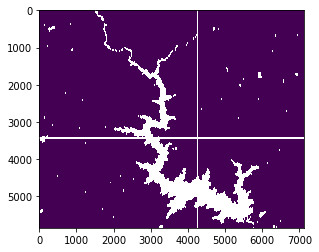

In [24]:
plt.imshow(out)

In [75]:
print(out.shape)
#out.data

(5853, 7128)


In [25]:
# scale data
# TODO try other scalers, such as StandardScaler
min_max_scaler = MinMaxScaler()
ar_minmax = min_max_scaler.fit_transform(ar)
ar_minmax

array([[0.76926219, 0.13041019, 0.69410202, 0.72588015, 0.5568801 ,
        0.13199149],
       [0.76687701, 0.13031137, 0.69481272, 0.7173112 , 0.55401992,
        0.12466364],
       [0.76493951, 0.12963434, 0.68868605, 0.71571121, 0.54973745,
        0.12456268],
       ...,
       [0.7680673 , 0.0765695 , 0.70559013, 0.73884848, 0.65163806,
        0.08277629],
       [0.74992993, 0.0909106 , 0.67521846, 0.74334933, 0.64290797,
        0.0926338 ],
       [0.74529081, 0.09877303, 0.68162927, 0.74211088, 0.64498151,
        0.09656597]])

## Principal component analysis for dimension reduction
https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e \
https://stackoverflow.com/a/56710906

**To find most important features:**
```most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]``` or ```print(abs( pca.components_ ))``` (Here, pca.components_ has shape [n_components, n_features] Thus, by looking at the PC1 (first Principal Component) which is the first row, we can conclude that feature 1, 3 and 4 are the most important for PC1.)

**To use PCs only:**
```pca.fit_transform(X)```

In [77]:
# do principal component analysis 
pca = PCA(n_components = 5)
ar_pc = pca.fit_transform(ar_minmax)
print(pca.explained_variance_ratio_)
# test dataset: the first component explains by far the most, around 98% (old)
# with masked water, C1 and C2 seem both important
# with masked water, without swir, C1 has 65%, C2 17%, C3 7%; biggest in C1 = NDVI
# with masked water, without swir, without AOI: [0.5877071  0.19261288 0.09831868 0.06897447 0.03444695]


[0.5877071  0.19261288 0.09831868 0.06897447 0.03444695]


In [78]:
np.round(pca.components_, 2)
# C1: B1, 5, 6
# C2: 5,7,9
# C3: 4, 11

array([[ 0.41,  0.24,  0.19, -0.09, -0.73,  0.31,  0.22, -0.19,  0.11,
         0.03],
       [ 0.09,  0.12,  0.06,  0.15, -0.01, -0.64,  0.63,  0.1 ,  0.17,
        -0.32],
       [ 0.27,  0.22,  0.14,  0.84,  0.17,  0.04, -0.25, -0.22,  0.1 ,
         0.01],
       [-0.09,  0.02, -0.03, -0.03,  0.09, -0.23,  0.28, -0.54, -0.12,
         0.74],
       [-0.2 , -0.09, -0.05, -0.18,  0.11,  0.06, -0.08, -0.62,  0.62,
        -0.34]])

In [79]:
ar_pc.shape

(8633588, 5)

## k-means classification

In [26]:
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=15)
# kmeans.fit(ar_pc)
kmeans.fit(ar_minmax)

KMeans(n_clusters=10, n_init=15)

In [27]:
# extract labelled pixels and place them in the masked array
labels = kmeans.labels_
np.place(out,~out.mask, labels)
# labelled_image = kmeans.labels_.reshape((width, height))

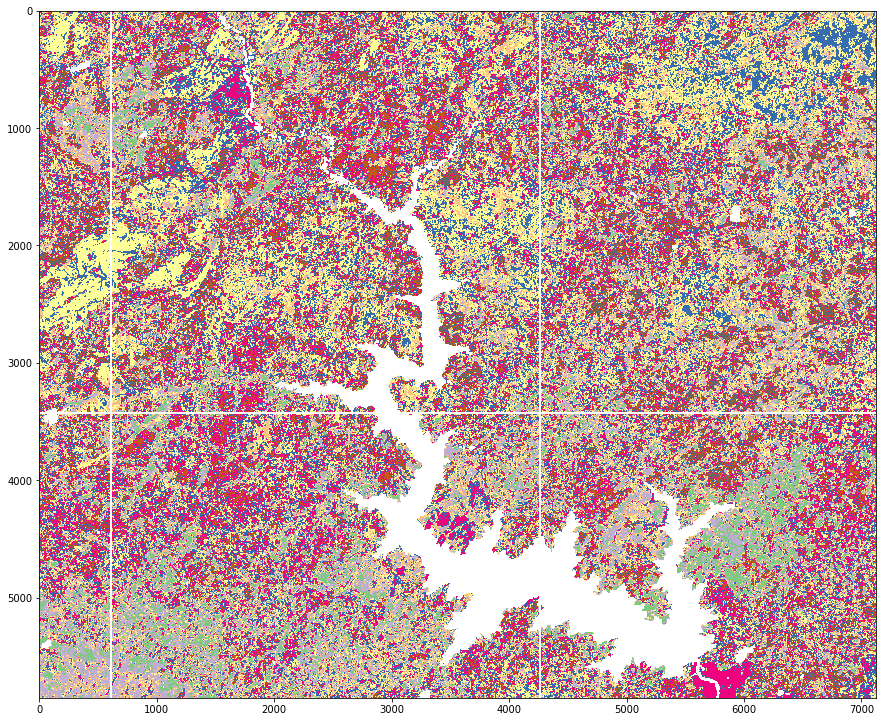

In [28]:
# visualize result
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(out, cmap='Accent') # best color differences: nipy_spectral, 

In [30]:
# extract data from masked array and write to .tif

labelled_image = np.ma.getdata(out).astype(int)
# if zeros are a problem: labelled_image = labelled_image + 1

array_to_geotiff('kmeans_n{}_tct.tif'.format(n_clusters),
                 data=labelled_image,
                 geo_transform=gdal_transform,
                 projection=proj,
                 nodata_val= nodataval)

In [5]:
# loop to find out optimal number of components for PCA

## Random Forest classification

In [32]:
td = ['Burkina Faso//split_trainingzones//BF-tp1.shp',
      'Burkina Faso//split_trainingzones//BF-tp2.shp',
      'Burkina Faso//split_trainingzones//BF-tp3.shp',
      'Burkina Faso//split_trainingzones//BF-tp4.shp',
      'Burkina Faso//split_trainingzones//BF-tp5.shp',
      'Burkina Faso//split_trainingzones//BF-tp6.shp',
      'Burkina Faso//split_trainingzones//BF-tp7.shp',
      'Burkina Faso//split_trainingzones//BF-tp8.shp',
      'Burkina Faso//split_trainingzones//BF-tp9.shp',
      'Burkina Faso//split_trainingzones//BF-tp10.shp',
      'Burkina Faso//split_trainingzones//BF-tp11.shp'
     ]

# to only use the RELIABLE = 1 shapes (which does make it worse)
reltd = ['Burkina Faso//split_trainingzones//BF-reltp1.shp',
         'Burkina Faso//split_trainingzones//BF-reltp2.shp',
         'Burkina Faso//split_trainingzones//BF-reltp3.shp',
         'Burkina Faso//split_trainingzones//BF-reltp4.shp',
         'Burkina Faso//split_trainingzones//BF-reltp5.shp'
        ]

In [34]:
def load_function(query):
    '''
    load and combine data from two timespans, using prepare_one_timestep and the query format which is used in the classification utils skript.
    stress is on time2: from time1, only 3 indices are used and appended as spring_* to time2 data.
    '''
    print('first timestep:')
    composite1 = prepare_one_timestep(
                      inlat = query['y'],
                      inlon = query['x'],
                      intime = query['time1'])
    print('second timestep:')
    composite2 = prepare_one_timestep(
                      inlat = query['y'],
                      inlon = query['x'],
                      intime = query['time2'])
    
    composite2['spring_ndvi'] = composite1.ndvi
    composite2['spring_mndwi'] = composite1.mndwi
    composite2['spring_ndbi'] = composite1.ndbi
    
    return composite2

### Actual classification

In [35]:
# define time steps + output file
time1 = ('2019-03-01', '2019-05-30')
time2 = ('2019-10-01', '2019-11-30')
outf = 'BF_rf_aftertct.tif'
trainingdata = td

In [41]:
# train classifier
classifier, samples, labels = randomforest_train(
                                train_shps = trainingdata,
                                train_field='CLASS',
                                data_func=tc_two_timesteps, #load_function,
                                data_func_params={'time1': time1,
                                                  'time2': time2},
                                classifier_params={},
                                train_reclass=None)

Importing training data from Burkina Faso//split_trainingzones//BF-tp1.shp:
New Query: {'x': (-0.8976436510592033, -0.5281917529789582), 'y': (11.453772510471914, 11.506030343700193), 'crs': 'epsg:4326', 'time1': ('2019-03-01', '2019-05-30'), 'time2': ('2019-10-01', '2019-11-30')}
preparing first timestep...
9 out of 9 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 6 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...
Importing training data from Burkina Faso//split_trainingzones//BF-tp2.shp:
New Query: {'x': (-0.9133944066551647, -0.5149488391459335), 'y': (11.491729570413092, 11.532095677264964), 'crs': 'epsg:4326', 'time1': ('2019-03-01', '2019-05-30'), 'time2': ('2019-10-01', '2019-11-30')}
preparing first timestep...
9 out of 9 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 6 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...
Importing training data from Burkina Faso//split_trainingzones//BF-tp3.shp:
New Query: {'x': (-0.9021713130517125, -0.518161280868756), 'y': (11.516443148160505, 11.559615913113635), 'crs': 'epsg:4326', 'time1': ('2019-03-01', '2019-05-30'), 'time2': ('2019-10-01', '2019-11-30')}
preparing first timestep...
9 out of 9 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 6 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...
Importing training data from Burkina Faso//split_trainingzones//BF-tp4.shp:
New Query: {'x': (-0.8948614093565661, -0.5306997118759976), 'y': (11.54199825997041, 11.58406027189057), 'crs': 'epsg:4326', 'time1': ('2019-03-01', '2019-05-30'), 'time2': ('2019-10-01', '2019-11-30')}
preparing first timestep...
9 out of 9 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 6 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...
Importing training data from Burkina Faso//split_trainingzones//BF-tp5.shp:
New Query: {'x': (-0.8669983261758972, -0.4857436505553942), 'y': (11.572042860106023, 11.622714825924664), 'crs': 'epsg:4326', 'time1': ('2019-03-01', '2019-05-30'), 'time2': ('2019-10-01', '2019-11-30')}
preparing first timestep...
9 out of 9 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 6 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...
Importing training data from Burkina Faso//split_trainingzones//BF-tp6.shp:
New Query: {'x': (-1.0408146970029581, -0.44374901351464424), 'y': (11.606790021474925, 11.676588380385683), 'crs': 'epsg:4326', 'time1': ('2019-03-01', '2019-05-30'), 'time2': ('2019-10-01', '2019-11-30')}
preparing first timestep...
9 out of 21 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 12 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...
Importing training data from Burkina Faso//split_trainingzones//BF-tp7.shp:
New Query: {'x': (-1.0426453585096058, -0.41483818269433365), 'y': (11.660109346991634, 11.693638976576786), 'crs': 'epsg:4326', 'time1': ('2019-03-01', '2019-05-30'), 'time2': ('2019-10-01', '2019-11-30')}
preparing first timestep...
9 out of 21 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 12 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...
Importing training data from Burkina Faso//split_trainingzones//BF-tp8.shp:
New Query: {'x': (-0.9200706363986764, -0.4198544621692053), 'y': (11.681220675586863, 11.73263852638108), 'crs': 'epsg:4326', 'time1': ('2019-03-01', '2019-05-30'), 'time2': ('2019-10-01', '2019-11-30')}
preparing first timestep...
9 out of 21 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 12 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...
Importing training data from Burkina Faso//split_trainingzones//BF-tp9.shp:
New Query: {'x': (-0.839840951832397, -0.41905777112079506), 'y': (11.723511186185423, 11.84329591482078), 'crs': 'epsg:4326', 'time1': ('2019-03-01', '2019-05-30'), 'time2': ('2019-10-01', '2019-11-30')}
preparing first timestep...
9 out of 21 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 12 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...
Importing training data from Burkina Faso//split_trainingzones//BF-tp10.shp:
New Query: {'x': (-0.9248689193780569, -0.6848622366295699), 'y': (11.839718940613237, 11.907705377936805), 'crs': 'epsg:4326', 'time1': ('2019-03-01', '2019-05-30'), 'time2': ('2019-10-01', '2019-11-30')}
preparing first timestep...
9 out of 21 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 12 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...
Importing training data from Burkina Faso//split_trainingzones//BF-tp11.shp:
New Query: {'x': (-0.8929786507120988, -0.6050036193108629), 'y': (11.89959291717125, 11.969806007553444), 'crs': 'epsg:4326', 'time1': ('2019-03-01', '2019-05-30'), 'time2': ('2019-10-01', '2019-11-30')}
preparing first timestep...
9 out of 21 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 12 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...

Training random forest classifier...
Model trained on 6 bands and 360546 training samples


In [43]:
# load and prepare dataset to classify
#dataset = load_function({'x':longitude_extents,
#                         'y':latitude_extents,
#                         'time1':time1,
#                         'time2':time2
#                        })
#dataset = ds
# run classification, save output
classified, probabilities = randomforest_classify(classifier = classifier,
                                   analysis_data = ds, #dataset,
                                   classification_output = outf,
                                   class_prob=True)

Data to classify:
  Rows: 5853
  Columns: 7128
  Bands: 6

Classification processing...
  2266342 nodata cells removed
  Classification exported

Class probability processing...


KeyboardInterrupt: 

# done
- upload shapefile of aoi and training dataset
- clean folder with old data
- define indices
- split training data into smaller chunks
- first classification
- include indices in training and classification
- repair file
- also try sentinel
- make median composites for two seasons and use together
- write 'load' function for composite analysis
- do more timesteps
- classify unsupervisedly to possibly find differences between cropland and grassland (k-means)
- remove water, na pixels before k-means
- try to PCA speed up/improve it?
- preprocessing: scale all values, also for r
- mask the area outside the AOI, too

### some tricks to keep

In [2]:
dc.list_measurements().loc['s2_l2a_burkinafaso']

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
coastal_aerosol,coastal_aerosol,uint16,reflectance,0,"[band_1, coastal_aerosol]",NaN
blue,blue,uint16,reflectance,0,"[band_2, blue]",NaN
green,green,uint16,reflectance,0,"[band_3, green]",NaN
red,red,uint16,reflectance,0,"[band_4, red]",NaN
veg5,veg5,uint16,reflectance,0,"[band_5, veg5]",NaN
veg6,veg6,uint16,reflectance,0,"[band_6, veg6]",NaN
veg7,veg7,uint16,reflectance,0,"[band_7, veg7]",NaN
nir,nir,uint16,reflectance,0,"[band_8, nir]",NaN
narrow_nir,narrow_nir,uint16,reflectance,0,"[band_8a, narrow_nir]",NaN


In [9]:
ds = tc_two_timesteps(time1, time2, latitude_extents, longitude_extents)

preparing first timestep...
9 out of 21 entries were usable


cleaning dataset
making composite...
performing tct...
preparing second timestep...
6 out of 12 entries were usable


cleaning dataset
making composite...
performing tct...
combining datasets...


In [33]:
ds

<xarray.Dataset>
Dimensions:            (latitude: 5853, longitude: 7128)
Coordinates:
  * latitude           (latitude) float64 11.98 11.98 11.98 ... 11.45 11.45
  * longitude          (longitude) float64 -1.056 -1.056 ... -0.4064 -0.4063
    spatial_ref        int32 4326
Data variables:
    greenness          (latitude, longitude) float64 295.2 261.2 ... 19.71 -46.4
    brightness         (latitude, longitude) float64 4.48e+03 ... 3.639e+03
    wetness            (latitude, longitude) float64 -2.411e+03 ... -2.555e+03
    greenness_spring   (latitude, longitude) float64 -1.122e+03 ... -952.3
    wetness_spring     (latitude, longitude) float64 -4.749e+03 ... -3.689e+03
    brightness_spring  (latitude, longitude) float64 5.605e+03 ... 4.775e+03
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

***
## Additional information

<font size="2">This notebook for the usage in the Open Data Cube entities of the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/), is adapted from [Geoscience Australia](https://github.com/GeoscienceAustralia/dea-notebooks), published using the Apache License, Version 2.0. Thanks! </font>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/eo2cube).

**Last modified:** January 2021

**Compatible datacube version:** 

In [10]:
print(datacube.__version__)

1.8.3
